# An√°lisis de la red de *tweets* y usuarios relacionados con la final de la Liga Uruguaya de Basketball (LUB).






## Trabajo final del curso "De las redes complejas a las redes sociales: Introducci√≥n al Uso del Big Data"


### Integrantes del equipo: 

- Andrea Apolaro
- Guzm√°n L√≥pez
- Leticia Vidal
- Ricardo Rezzano


## Introducci√≥n

En el marco del curso ...



## Metodolog√≠a

Se utiliz√≥ el lenguaje de programaci√≥n Python (versi√≥n 3.6.1) ...

### Importar librer√≠as 

In [1]:
# Import python libraries
import tweepy
import time
from random import choice
from py2neo import authenticate, Graph
import cypher
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Autenticaci√≥n de Twitter y Neo4j mediante la lectura de un archivo externo con las claves requeridas:

In [8]:
# Twitter OAuthentication
consumer_key = "XXXXXXXXXX"
consumer_secret = "XXXXXXXXXX"
access_token = "XXXXXXXXXX"
access_token_secret = "XXXXXXXXXX"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Neo4j
neo4jUser = "xxxx"
neo4jPass = "xxxx"

In [2]:
# Authentication credentials for Tweeter and Neo4j credentials
with open('/home/guzman/Documentos/Cursos/Redes Complejas - Introducci√≥n al uso del Big Data/Python/twitter-OAuth.py') as oauth:
    exec(oauth.read())

### Crear la API (Application Program Interface) de Twitter:

In [3]:
# Create API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

### Comenzar el servicio de la base de datos Neo4j desde una consola:

In [4]:
%%sh

# Start neo4j service 
systemctl start neo4j.service

# Check status of neo4j service
systemctl status neo4j.service

‚óè neo4j.service - Neo4j
   Loaded: loaded (/usr/lib/systemd/system/neo4j.service; disabled; vendor preset: disabled)
   Active: active (running) since Thu 2017-06-08 10:13:41 -03; 4ms ago
  Process: 3895 ExecStart=/usr/bin/neo4j start (code=exited, status=0/SUCCESS)
 Main PID: 3955 (java)
    Tasks: 36 (limit: 4915)
   Memory: 22.6M
      CPU: 134ms
   CGroup: /system.slice/neo4j.service
           ‚îî‚îÄ3955 /usr/sbin/java -cp /usr/share/java/neo4j/plugins:/etc/neo4j:/usr/share/java/neo4j/*:/usr/share/java/neo4j/plugins/* -server -XX:+UseG1GC -XX:-OmitStackTraceInFastThrow -XX:hashCode=5 -XX:+AlwaysPreTouch -XX:+UnlockExperimentalVMOptions -XX:+TrustFinalNonStaticFields -XX:+DisableExplicitGC -Djdk.tls.ephemeralDHKeySize=2048 -Dunsupported.dbms.udc.source=tarball -Dfile.encoding=UTF-8 org.neo4j.server.CommunityEntryPoint --home-dir=/usr/share/neo4j --config-dir=/etc/neo4j

jun 08 10:13:41 carqueja systemd[1]: Starting Neo4j...
jun 08 10:13:41 carqueja neo4j[3895]: Starting Neo4j.
ju

### Autenticaci√≥n de la base de datos no relacional Neo4j a trav√©s de la lectura del archivo externo con las claves de usuario y contrase√±a requeridas le√≠do anteriormente.

In [6]:
# Neo4j DB graph authentication

# Connect to graph
url = "http://localhost:7474/db/data/"
authenticate("localhost:7474", neo4jUser, neo4jPass)
graph = Graph(url)

# Authentication for cypher package
connPar = "http://" + neo4jUser + ":" + neo4jPass + "@localhost:7474/db/data/"

### Agregar restricciones de unicidad a la base de datos:

In [ ]:
# Add uniqueness constraints
graph.run("CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.screen_name IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (l:Link) ASSERT l.url IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (s:Source) ASSERT s.name IS UNIQUE;")

### Construir una lista con las palabras clave para la b√∫squeda de tweets:

In [16]:
# Query words
queries = ["aguada", "aguatero", "hebraica", "macabi", "finalesLUB", "juntosporlanovena", "vamossha", "finaleslub"]

### Crear un archivo de texto vac√≠o para adjuntar (escribir) los nombres de los usuarios de los tweets encontrados:

In [ ]:
# Open file connection to append usernames
ufile = open("usernames_{}.txt".format("aguada-hebraica"), "a")

### Cargar script de comandos en Cypher como cadena de caracteres

In [7]:
# Pass dict to Cypher and build query from cypher script file
with open('/home/guzman/Documentos/GitLab/ComplexNetworks/Cypher/queries-in-script.cypher') as query:
    query = query.read()

print(query)

UNWIND {tweets} AS t

WITH t
ORDER BY t.id

WITH t,
t.entities AS e,
t.user AS u,
t.retweeted_status AS retweet

MERGE (tweet:Tweet {id:t.id})
SET tweet.text = t.text,
tweet.created_at = t.created_at,
tweet.favorites = t.favorite_count

MERGE (user:User {screen_name:u.screen_name})
SET user.name = u.name,
user.location = u.location,
user.followers = u.followers_count,
user.following = u.friends_count,
user.statuses = u.statuses_count,
user.profile_image_url = u.profile_image_url

MERGE (user)-[:POSTS]->(tweet)

MERGE (source:Source {name:t.source})
MERGE (tweet)-[:USING]->(source)

FOREACH (h IN e.hashtags |
  MERGE (tag:Hashtag {name:LOWER(h.text)})
  MERGE (tag)-[:TAGS]->(tweet)
  )

  FOREACH (u IN e.urls |
    MERGE (url:Link {url:u.expanded_url})
    MERGE (tweet)-[:CONTAINS]->(url)
    )

    FOREACH (m IN e.user_mentions |
      MERGE (mentioned:User {screen_name:m.screen_name})
      ON CREATE SET mentioned.name = m.name
      MERGE (tweet)-[:MENTIONS]->(mentioned)
      )

   

### Definir los par√°metros para la b√∫squeda de los tweets:

In [ ]:
# Parameters
count = 100 # The number of tweets to return per page, up to a maximum of 100. Defaults to 15.
result_type = "mixed" # Include both popular and real time results in the response.
until = "2017-06-04" # Returns tweets created before the given date.
lang = "es" # Restricts tweets to the given language
since_id = -1 # Returns results with an ID greater than (that is, more recent than) the specified ID.

### Definir una funci√≥n para la b√∫squeda de tweets que contiene la funci√≥n de b√∫squeda de tweets de la librer√≠a tweepy y recibe como par√°metros las palabras clave de b√∫squeda y el ID.

In [ ]:
def search_tweets(query, since_id):
    return api.search(q=query, count=count, until=until, result_type=result_type, lang=lang, since_id=since_id)

### Iterar buscando tweets a partir de las palabras claves en la b√∫squeda y ejecutando el c√≥digo importado en Cypher para insertar los registros en la base de datos no relacional de Neo4j. 

In [ ]:
while True:
    try:
        q = choice(queries)
        tweets = search_tweets(q, since_id)
        if tweets:
            plural = "s." if len(tweets) > 1 else "."
            print("Found " + str(len(tweets)) + " tweet" + plural)
        else:
            print("No tweets found.\n")
            time.sleep(65)
            continue
        
        since_id = tweets[0].id

        # Send Cypher query.
        graph.run(query, tweets=[tweet._json for tweet in tweets])

        # adding users to user list
        for tweet in tweets:
            ufile.write(tweet.user.screen_name+"\n")
        print("Tweets added to graph! \n")
        time.sleep(33)

    except Exception as e:
        print(e)
        time.sleep(33)
        continue

### Crear objeto de grafos a partir de consulta a la base de datos Neo4j y ver su informaci√≥n:

In [9]:
# Query Neo4j
#results = cypher.run('MATCH usPostw=(:User)-[r:POSTS]->(:Tweet) \
#                      MATCH twRettw=(:Tweet)-[r2:RETWEETS]->(:Tweet) \
#                      MATCH twReptw=(:Tweet)-[r3:REPLY_TO]->(:Tweet) \
#                      MATCH twMenus=(:Tweet)-[r4:MENTIONS]->(:User) \
#                      RETURN usPostw,twRettw,twReptw,twMenus \
#                      LIMIT 100000;', conn=connPar)

results = cypher.run('MATCH (n:User)-[r]-(m:Tweet) \
                      RETURN n,r,m;', conn=connPar)

# Create graph object from Neo4j
g = results.get_graph()

# View info
print(nx.info(g))

442 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 402
Number of edges: 442
Average in degree:   1.0995
Average out degree:   1.0995


### Grafico simple del objeto de grafos:

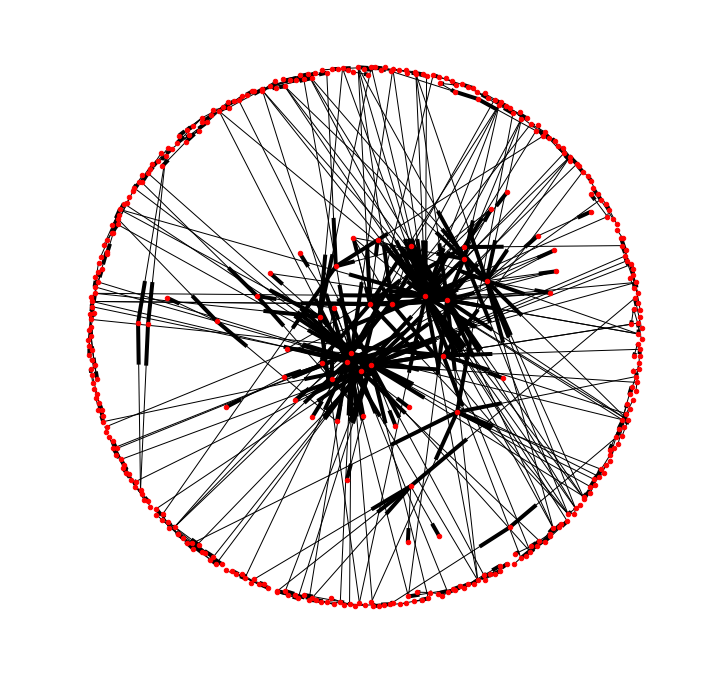

In [13]:
# Create network layout for visualizations
spring_pos = nx.spring_layout(g)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (12, 12)

plt.axis("off")
nx.draw_networkx(g, pos = spring_pos, with_labels = False, node_size = 20)

### Gr√°fico del grafo donde el tama√±o es directamente proporcional a la cantidad de conexiones de un nodo y as√≠ como tambi√©n la escala de colores del azul al rojo:

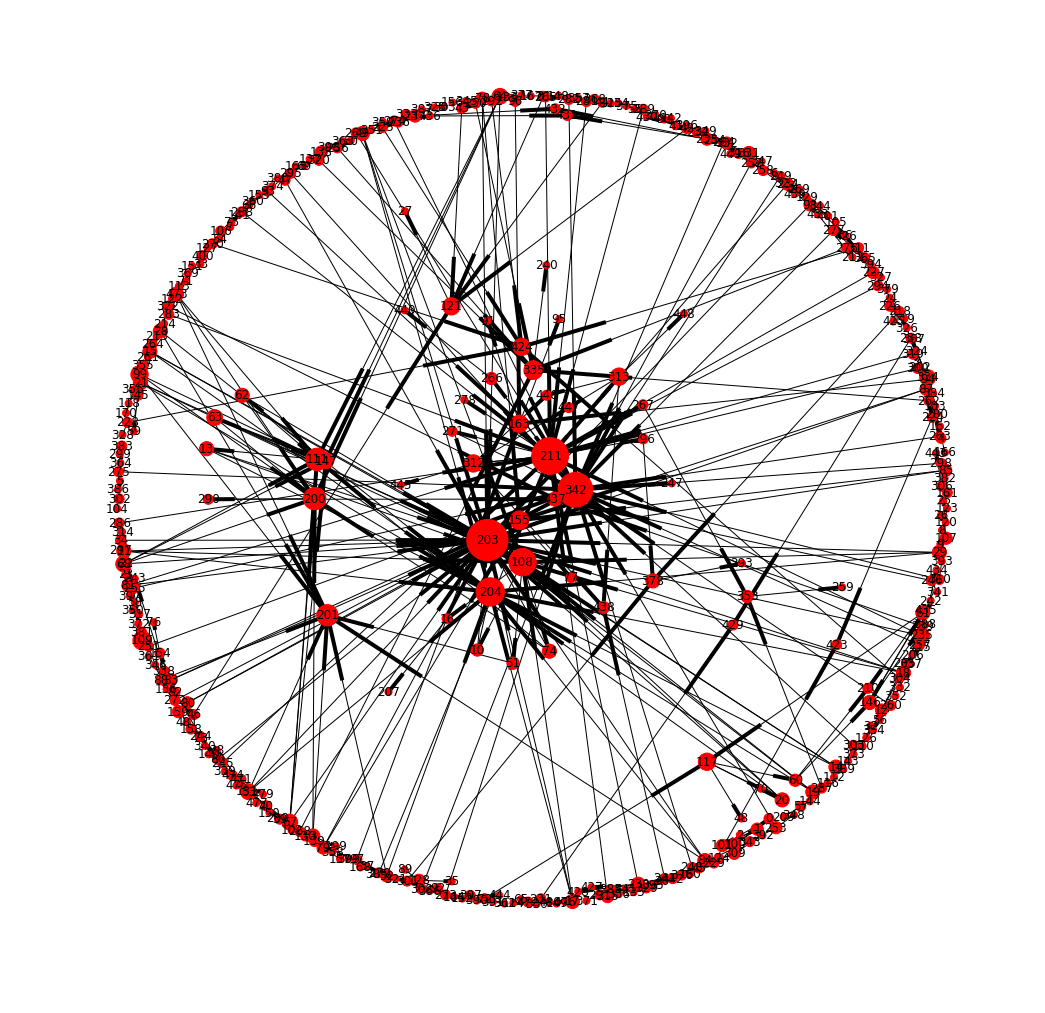

In [7]:
d = nx.degree(g)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (18, 18)

plt.axis("off")
nx.draw_networkx(g, pos = spring_pos, with_labels = True, nodelist=d.keys(), node_size=[v * 50 for v in d.values()])

### Ver nodos:

In [8]:
# View first five nodes
i = 0
for i in range(0,5):
    print(str(i + 1) + "- " + str(g.nodes(data=True)[i]))
    i = i + 1

1- ('1', {'favorites': 0, 'created_at': 'Wed May 31 21:14:07 +0000 2017', 'id': 870025622801838080, 'text': 'RT @KarinaAguatera: tamos ah√≠ @sandynyordi #JuntosPorLaNovena https://t.co/x2kWrWLrS2', 'labels': ['Tweet']})
2- ('100', {'followers': 190, 'screen_name': 'KarinaAguatera', 'following': 964, 'name': '@JAKCARBONEROS', 'statuses': 1725, 'profile_image_url': 'http://pbs.twimg.com/profile_images/871221543908638720/x4FSyHJs_normal.jpg', 'location': 'montevideo', 'labels': ['User']})
3- ('2', {'favorites': 1, 'created_at': 'Wed May 31 21:24:58 +0000 2017', 'id': 870028352631054336, 'text': 'mi trabajo de parto duro menos q sacar las entradas para la √∫ltima final. #JuntosPorLaNovena', 'labels': ['Tweet']})
4- ('0', {'favorites': 2, 'created_at': 'Wed May 31 21:03:11 +0000 2017', 'id': 870022870512152577, 'text': 'tamos ah√≠ @sandynyordi #JuntosPorLaNovena https://t.co/x2kWrWLrS2', 'labels': ['Tweet']})
5- ('101', {'followers': 24, 'screen_name': 'sandynyordi', 'following': 183, 'name

### Ver ejes:

In [10]:
# View first five edges
i = 0
for i in range(0,5):
    print(str(i + 1) + "- " + str(g.edges(data=True)[i]))
    i = i + 1

1- ('1', '100', {'type': 'MENTIONS'})
2- ('1', '101', {'type': 'MENTIONS'})
3- ('100', '2', {'type': 'POSTS'})
4- ('100', '0', {'type': 'POSTS'})
5- ('0', '101', {'type': 'MENTIONS'})


In [21]:
# Tipos de nodos (Usuarios y Tweets)

# Count User nodes
#resultsUserNodes = cypher.run('ALGO', conn=connPar)

# Consulta networkx
#fish2 = (n for n,d in G.nodes_iter(data=True) if d['label']=='fish')

#resultsUserNodes.dataframe


### Calcular principales m√©tricas sobre el grafo total:

In [10]:
# Tipo de grafo
esMultigrafo = g.is_multigraph()
esDireccional = g.is_directed()
esConectado = nx.is_connected(g.to_undirected())

# N√∫mero de nodos y conexiones
numNod = nx.number_of_nodes(g)
numEdg = nx.number_of_edges(g)

# Grados de un nodo (m√°ximo, m√≠nimo, promedio)
deg = nx.degree(g)
in_degrees  = g.in_degree()
out_degrees  = g.out_degree()

# Componentes conectados
if not esConectado:
    g2 = g.to_undirected() # saco direccionalidad

# N√∫mero de componentes conectados
numConComp = nx.number_connected_components(g2)

# Resumen
print("| -------------------------------------------- |")
if esMultigrafo:
    print("| Tipo de grafo: Multigrafo") 
if  not esMultigrafo: 
    print("| Tipo de grafo: Simple")

if esDireccional:
    print("| Direccional: Si") 
if  not esDireccional: 
    print("| Direccional: No")

if esConectado:
    print("| Conectado: Si") 
if  not esConectado: 
    print("| Conectado: No")
print("| -------------------------------------------- |")
print("| N√∫mero de nodos:", str(numNod))
print("| N√∫mero de conexiones:", str(numEdg))
print("| -------------------------------------------- |")
print("| Grado m√°ximo entrada:", str(max(in_degrees.values())))
print("| Grado m√≠nimo entrada:", str(min(in_degrees.values())))
print("| Grado promedio entrada:", str(sum(in_degrees.values())/len(deg.values())))
print("| -------------------------------------------- |")
print("| Grado m√°ximo salida:", str(max(out_degrees.values())))
print("| Grado m√≠nimo salida:", str(min(out_degrees.values())))
print("| Grado promedio salida:", str(sum(out_degrees.values())/len(deg.values())))
print("| -------------------------------------------- |")
print("| Grado m√°ximo (no dir):", str(max(deg.values())))
print("| Grado m√≠nimo (no dir):", str(min(deg.values())))
print("| Grado promedio (no dir):", str(sum(deg.values())/len(deg.values())))
print("| -------------------------------------------- |")
print("| N√∫mero total de componentes conectados: %d" % nx.number_connected_components(g2))
print("| -------------------------------------------- |")

| -------------------------------------------- |
| Tipo de grafo: Multigrafo
| Direccional: Si
| Conectado: No
| -------------------------------------------- |
| N√∫mero de nodos: 402
| N√∫mero de conexiones: 442
| -------------------------------------------- |
| Grado m√°ximo entrada: 34
| Grado m√≠nimo entrada: 0
| Grado promedio entrada: 1.099502487562189
| -------------------------------------------- |
| Grado m√°ximo salida: 7
| Grado m√≠nimo salida: 0
| Grado promedio salida: 1.099502487562189
| -------------------------------------------- |
| Grado m√°ximo (no dir): 34
| Grado m√≠nimo (no dir): 1
| Grado promedio (no dir): 2.199004975124378
| -------------------------------------------- |
| N√∫mero total de componentes conectados: 45
| -------------------------------------------- |


### An√°lisis sobre los componentes conectados, m√©tricas en los subgrafos:

In [16]:
# Subgrafos de componentes conectados
g2_conComp = list(nx.connected_component_subgraphs(g2))

# Definir funci√≥n con las m√©tricas adentro
def metricas_subgrafos(subgrafo):
    
    # crear diccionario vac√≠o
    dict = {}
    
    # m√©tricas
    numNodos = nx.number_of_nodes(subgrafo) # n√∫mero de nodos
    numConex = nx.number_of_edges(subgrafo) # n√∫mero de conexiones
    grados = nx.degree(subgrafo) # grados
    maxGrado = max(grados.values()) # grado max
    minGrado = min(grados.values()) # grado min
    promGrado = sum(grados.values())/len(grados.values())
    diametro = nx.diameter(subgrafo) # di√°metro
    radio = nx.radius(subgrafo) # radio
    excentricidad = nx.eccentricity(subgrafo) # excentricidad
    centro = nx.center(subgrafo) # centro
    periferia = nx.periphery(subgrafo) # periferia
    densidad = nx.density(subgrafo) # densidad
    between = nx.betweenness_centrality_source(subgrafo) # betweenness
    closeness = nx.closeness_centrality(subgrafo) # closeness
        
    # agregar m√©tricas al diccionario
    dict['nodos'] = numNodos
    dict['conexiones'] = numConex
    dict['grados'] = grados
    dict['maxgrado'] = maxGrado
    dict['mingrado'] = minGrado
    dict['promGrado'] = promGrado
    dict['di√°metro'] = diametro
    dict['radio'] = radio
    dict['excentricidad'] = excentricidad
    dict['centro'] = centro
    dict['periferia'] = periferia
    dict['densidad'] = densidad
    dict['betweenness'] = between
    dict['closeness'] = closeness
        
    # retorno
    return dict

# Aplicar funci√≥n metricas_subgrafos a todos los subgrafos
listaMetSubg = []

for subg in g2_conComp:
    subgMet = metricas_subgrafos(subg)
    listaMetSubg.append(subgMet)

# Ver m√©tricas y plot del subgrafo principal: donde esta≈Ñ los nodos m√°s importantes
import pandas as pd

for x in range(0,len(listaMetSubg)):
    for v in listaMetSubg[x].values():
        if(isinstance(v, list)):
            for w in v:
                if(w == '211'):
                    myDict = listaMetSubg[x]
                    i = x
                    
# Hacer dataframe
df = pd.DataFrame()
df['Par√°metro'] = myDict.keys()
df['Valores'] = myDict.values()

print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(df)
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        Par√°metro                                            Valores
0           nodos                                                244
1      conexiones                                                325
2          grados  {'308': 2, '232': 2, '247': 1, '113': 1, '345'...
3        maxgrado                                                 34
4        mingrado                                                  1
5       promGrado                                            2.66393
6        di√°metro                                                 16
7           radio                                                  8
8   excentricidad  {'308': 11, '232': 11, '247': 11, '113': 12, '...
9          centro                                              [211]
10      periferia                                         [436, 341]
11       densidad                                          0.0109627
12    betweenness  {'308': 0.008

### Figuras del grafo m√°s importante:

El tama√±o de los nodos es proporcional al grado del mismo y el color azul representa mayor betweenness

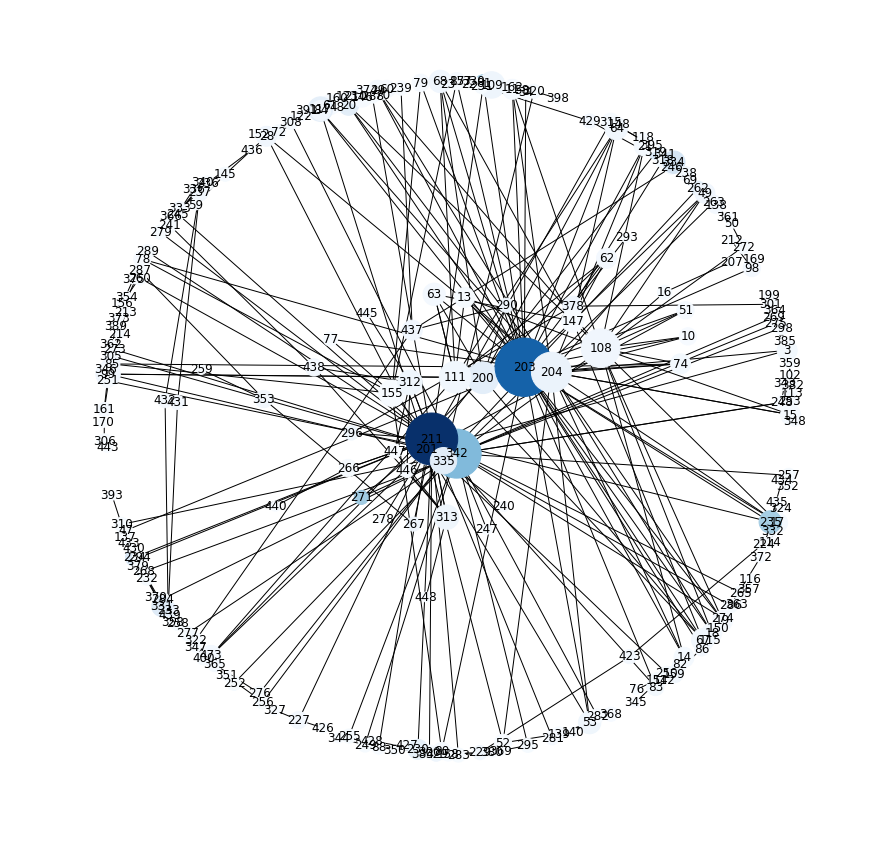

In [18]:
# Grados subgrafo
d = nx.degree(g2_conComp[i])
b = nx.betweenness_centrality(g2_conComp[i])

# Plot subgrafo
matplotlib.rcParams['figure.figsize'] = (15,15)
plt.axis("off")
nx.draw_networkx(g2_conComp[i], pos = spring_pos, with_labels = True, 
                 nodelist=d.keys(), node_size=[v * 100 for v in d.values()], 
                 cmap=plt.get_cmap('Blues'), node_color=[v for v in b.values()])


El tama√±o de los nodos es proporcional al grado del mismo y el color azul representa mayor closeness

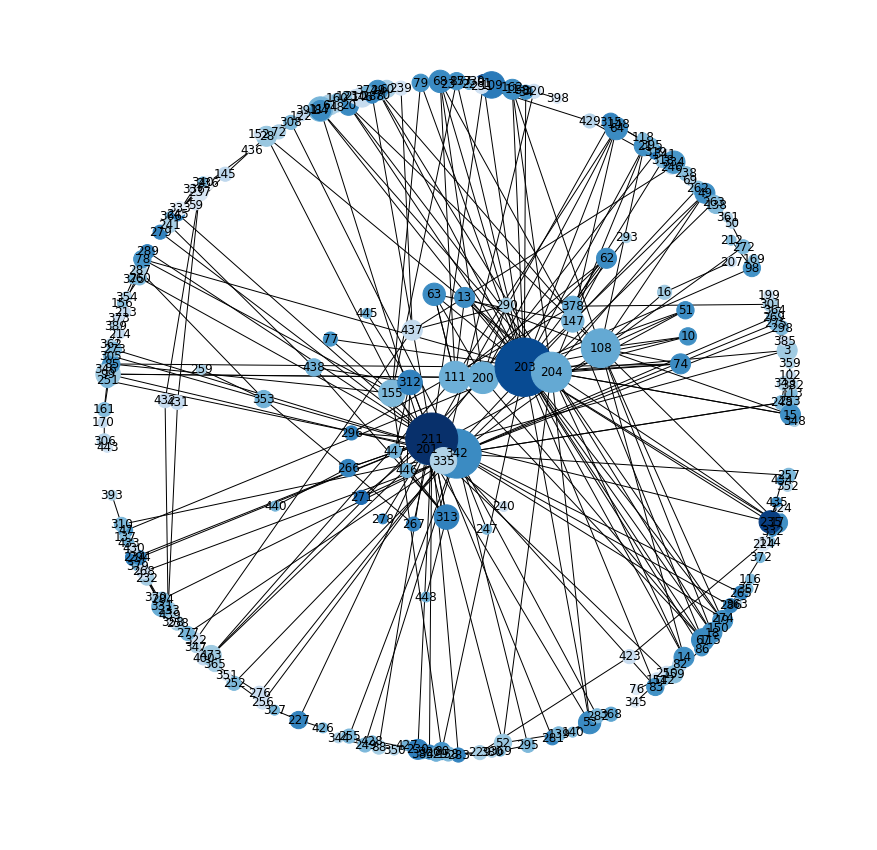

In [17]:
# Grados subgrafo
c = nx.closeness_centrality(g2_conComp[i])

# Plot subgrafo
matplotlib.rcParams['figure.figsize'] = (15,15)
plt.axis("off")

nx.draw_networkx(g2_conComp[i], pos = spring_pos, with_labels = True, 
                 nodelist=d.keys(), node_size=[v * 100 for v in d.values()], 
                 cmap=plt.get_cmap('Blues'), node_color=[v for v in c.values()])

### Seleccionar el id, nombre y grado de los 10 nodos con m√°s conexiones de salida:

In [41]:
# Select most output connected nodes
resultsDegOut = cypher.run('MATCH (n:User)-[r]->(m:Tweet) \
                            RETURN id(n) AS ID, n.screen_name AS NOMBRE, count(*) AS GRADO \
                            ORDER BY GRADO DESC LIMIT 10', conn=connPar)

resultsDegOut.dataframe

10 rows affected.


ID           NOMBRE  GRADO
0  109   CesarGroba2016      7
1  211  Hebraicaymacabi      7
2  334        AKolender      5
3  117       alcaide943      4
4  131  carlosRocha1891      4
5  331         MSTM1215      4
6  108        daianab81      4
7  132        Macucha23      3
8  107    EduuCabrera19      3
9  159   DanielaBrandon      3

### Seleccionar el id, nombre y grado de los 10 nodos con m√°s conexiones de entrada:

In [40]:
# Select most intput connected nodes
resultsDegIn = cypher.run('MATCH (n:User)<-[r]-(m:Tweet) \
                           RETURN id(n) AS ID, n.screen_name AS NOMBRE, count(*) AS GRADO \
                           ORDER BY GRADO DESC LIMIT 10', conn=connPar)

resultsDegIn.dataframe

10 rows affected.


ID           NOMBRE  GRADO
0  203   Aguada_oficial     34
1  342           LUB_Uy     23
2  211  Hebraicaymacabi     20
3  204   RinconAguatero     16
4  108        daianab81     11
5  200   PasionAguatera      9
6  201        HAguatera      9
7  111     Somos_Aguada      8
8  424     elmarcadortv      6
9  335         alenb259      6

### Ver gr√°ficos con los IDs con m√°s conexiones de entrada:

93 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 81
Number of edges: 93
Average in degree:   1.1481
Average out degree:   1.1481


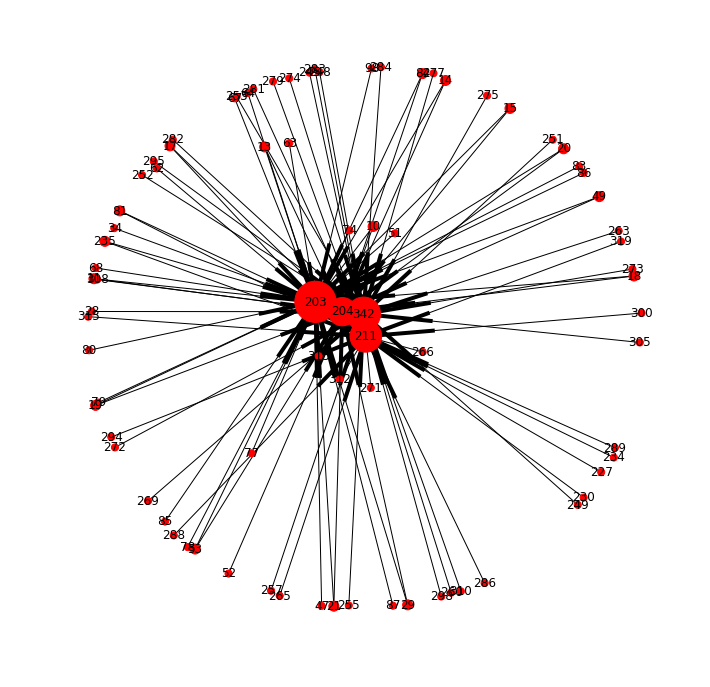

In [67]:
matplotlib.rcParams['figure.figsize'] = (12, 12)

resultsInDeg = cypher.run('MATCH a=(n:User)<-[r]-(m:Tweet) \
                           WHERE n.screen_name = "Aguada_oficial" \
                           OR n.screen_name = "LUB_Uy"\
                           OR n.screen_name = "Hebraicaymacabi" \
                           OR n.screen_name = "RinconAguatero" \
                           RETURN a;', conn=connPar)

# Create graph object from Neo4j
gInDeg = resultsInDeg.get_graph()

# View info
print(nx.info(gInDeg))

dInDeg = nx.degree(gInDeg)

# Plot graph
plt.axis("off")
nx.draw_networkx(gInDeg, pos = spring_pos, with_labels = True, nodelist=dInDeg.keys(), node_size=[v * 50 for v in dInDeg.values()])

### Ver gr√°ficos con los IDs con m√°s conexiones de salida:

19 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 22
Number of edges: 19
Average in degree:   0.8636
Average out degree:   0.8636


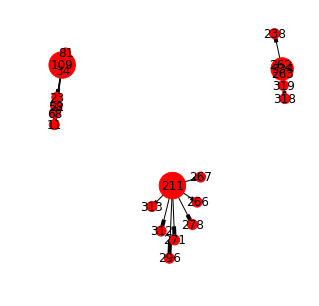

In [69]:
resultsOutDeg = cypher.run('MATCH a=(n:User)-[r]->(m:Tweet) \
                            WHERE n.screen_name = "CesarGroba2016" \
                            OR n.screen_name = "Hebraicaymacabi"\
                            OR n.screen_name = "AKolender" \
                            RETURN a;', conn=connPar)

# Create graph object from Neo4j
gOutDeg = resultsOutDeg.get_graph()

# View info
print(nx.info(gOutDeg))

dOutDeg = nx.degree(gOutDeg)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (5, 5)
plt.axis("off")
nx.draw_networkx(gOutDeg, pos = spring_pos, with_labels = True, nodelist=dOutDeg.keys(), node_size=[v * 100 for v in dOutDeg.values()])

### Seleccionar el id, nombre y grado de los 10 nodos con m√°s conexiones (entrada y salida):

In [39]:
resultsDeg = cypher.run('MATCH (n:User)-[r]-(m:Tweet) \
                         RETURN id(n) AS ID, n.screen_name AS NOMBRE, count(*) AS GRADO \
                         ORDER BY GRADO DESC LIMIT 10', conn=connPar)

resultsDeg.dataframe


10 rows affected.


ID           NOMBRE  GRADO
0  203   Aguada_oficial     34
1  211  Hebraicaymacabi     27
2  342           LUB_Uy     24
3  204   RinconAguatero     16
4  108        daianab81     15
5  200   PasionAguatera     10
6  111     Somos_Aguada     10
7  201        HAguatera      9
8  155  Castro_AnaLaura      7
9  335         alenb259      7

### Ver gr√°ficos con los IDs con m√°s conexiones (entrada y salida):

39 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 22
Number of edges: 19
Average in degree:   0.8636
Average out degree:   0.8636


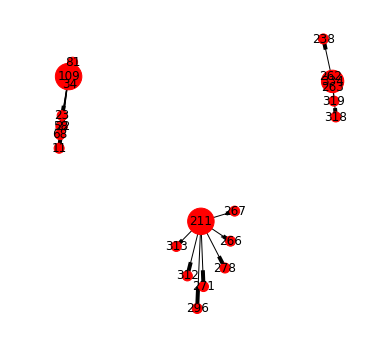

In [66]:
resultsInOutDeg = cypher.run('MATCH a=(n:User)-[r]-(m:Tweet) \
                              WHERE n.screen_name = "CesarGroba2016" \
                              OR n.screen_name = "Hebraicaymacabi"\
                              OR n.screen_name = "AKolender" \
                              RETURN a;', conn=connPar)

# Create graph object from Neo4j
gInOutDeg = resultsOutDeg.get_graph()

# View info
print(nx.info(gInOutDeg))

dInOutDeg = nx.degree(gInOutDeg)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (6, 6)
plt.axis("off")
nx.draw_networkx(gInOutDeg, pos = spring_pos, with_labels = True, nodelist=dInOutDeg.keys(), node_size=[v * 100 for v in dInOutDeg.values()])

### Seleccionar todas las palabras de los tweets de los dos nodos m√°s conectados para construir una nube de palabras:

In [109]:
# Nodo m√°s conectado
resultsText1 = cypher.run('MATCH a=(n:User)-[r]-(m:Tweet) \
                          WHERE n.screen_name = "Aguada_oficial" \
                          RETURN DISTINCT(m.text);', conn=connPar)

# Open file connection to append resultsText
textAguadaOficial = open("AguadaOficialTweetText.txt", "a")
textAguadaOficial.write(str(resultsText1)+"/n")

# Segundo nodo m√°s conectado
resultsText2 = cypher.run('MATCH a=(n:User)-[r]-(m:Tweet) \
                          WHERE n.screen_name = "Hebraicaymacabi" \
                          RETURN DISTINCT(m.text);', conn=connPar)

# Open file connection to append resultsText
textHebraicaymacabi = open("HebraicaymacabiTweetText.txt", "a")
textHebraicaymacabi.write(str(resultsText2)+"/n")


16 rows affected.
16 rows affected.


3191

Ver nodo m√°s conectado:

In [90]:
resultsText1.dataframe

(m.text)
0   RT @Mariog64: @Aguada_oficial @URUGUAYLATECAP ...
1   @cherrera88 @Aguada_oficial Eeeeeeeeee paaaara...
2   Es hoy #Juntosporlanovena üôåüèºüôåüèºüôåüèº @Aguada_ofici...
3   Y ac√° estamos! Vamos nosotros carajooo!!! #jun...
4   RT @Castro_AnaLaura: Es hoy #Juntosporlanovena...
5   40' para el salto inicial @Aguada_oficial vs @...
6   Es hoy @Aguada_oficial !!! Vamo arriba !! üí™üèΩ \...
7   Es hoy @Aguada_oficial ! #JuntosPorLaNovena #a...
8   Es hoy!!! Trato de concentrarme en el trabajo ...
9   Ya no puedo mas... Tiene que ser hoy!!! #Junto...
10  RT @Colet12: Cuando tu amiga hace la fila xa e...
11  RT @Titotimothytim: Ya no puedo mas... Tiene q...
12  RT @daianab81: A Palacio y Estadio Propio llen...
13     ES HOY @Aguada_oficial üíö‚ù§Ô∏è\n#juntosporlanovena
14  Que mejor que empezar esta ma√±ana de esta form...
15  A Palacio y Estadio Propio lleno!!! As√≠ se viv...

Ver segundo nodo m√°s conectado:

In [72]:
resultsText2.dataframe

(m.text)
0   RT @Hebraicaymacabi: La gloria: ¬°MacaBI! ¬°HACI...
1   RT @hundilacom: Cr√≥nica de la victoria de @Heb...
2   RT @Hebraicaymacabi: Sacamos 26! Abrazate! Hac...
3   RT @susanarosano1: @Hebraicaymacabi Felicitaci...
4   RT @Hebraicaymacabi: Final! Gan√≥ Macabi 82 a 5...
5   RT @MarioNBarbato: @OPetinatti @Hebraicaymacab...
6   RT @abifitcoach: @OPetinatti @Hebraicaymacabi ...
7   RT @Mariog64: @Aguada_oficial @URUGUAYLATECAP ...
8   RT @dobleyfalta_uy: #LUB | las mejores im√°gene...
9   @Hebraicaymacabi MacaBI CAMPE√ìN! Que huevo Heb...
10  RT @mago1377: @Hebraicaymacabi si se√±or un equ...
11  RT @Basketbol1010: los campeones Hebraica Maca...
12  La gloria: ¬°MacaBI! ¬°HACIENDO HISTORIA! https:...
13  RT @ElAguanteUy: Hebraica Macabi gan√≥ la LUB y...
14  RT @LUB_Uy: Video Clip de la 7ma FINAL de LUB ...
15  40' para el salto inicial @Aguada_oficial vs @...

### Construir nube de palabras y eliminar palabras no deseadas:

In [171]:
def cleanstr(filtro, fileStringName):

    import re
    
    # En primer lugar debemos de abrir el fichero que vamos a leer.
    # Usa 'rb' en vez de 'r' si se trata de un fichero binario.
    
    infile = open(fileStringName + '.txt', 'r')
    outfile = open(fileStringName + 'Clean.txt', 'w') # Indicamos el valor 'w'.
    outfile2 = open(fileStringName + 'Basura.txt', 'w') # Indicamos el valor 'w'.
    
    # Mostramos por pantalla y escribe en un fichero lo que leemos desde el fichero y filtramos
    print('>>> Lectura del fichero l√≠nea a l√≠nea')
    for line in infile:
        palabras = line.split()
        for n in palabras:
            if re.match('@.+', n):
                outfile2.write(n + "\n")
            elif re.match(" " + filtro + " ", n):
                print(n)
                #outfile2.writelines(n + "\n")
            elif re.match('https', n):
                outfile2.write(n + "\n")
            else:
                outfile.writelines(n + "\n")
                
    #    if re.match('(@.+)',line):
    #        cleanline= line
    #        print(line)
    #        outfile.write(cleanline)
    #    if re.search('^@', line):
    #        cleanline2=line
    #        print(cleanline2)
    #        outfile2.write(cleanline)
    
    # Cerramos el fichero.
    outfile.close()
    outfile2.close()
    infile.close()
    
    print('>>> Termina proceso con exito')

# Prueba:
cleanstr('httpsüòÇ', 'AguadaOficialTweetText')
cleanstr('https', 'HebraicaymacabiTweetText')

>>> Lectura del fichero l√≠nea a l√≠nea
>>> Termina proceso con exito
>>> Lectura del fichero l√≠nea a l√≠nea
>>> Termina proceso con exito


### Nube de palabras:

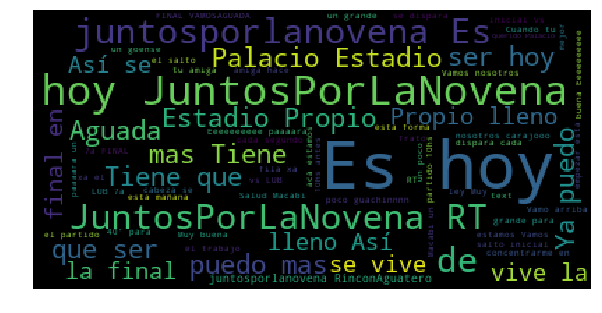

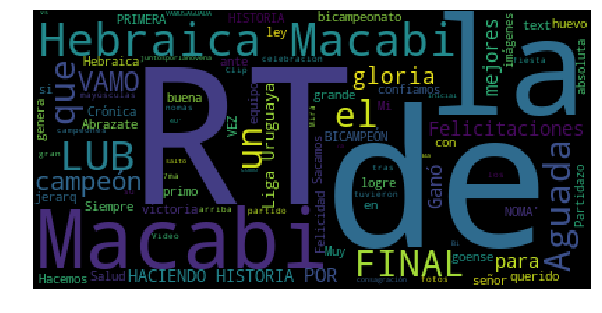

In [192]:
from wordcloud import WordCloud, STOPWORDS
matplotlib.rcParams['figure.figsize'] = (10, 10)

#Convert all the required text into a single string here and store them in word_string
# you can specify fonts, stopwords, background color and other options

word_string1 = ""

infile = open('AguadaOficialTweetTextClean.txt', 'r')
for l in infile:
    word_string1 = word_string1 + l

word_string2 = ""

infile = open('HebraicaymacabiTweetTextClean.txt', 'r')
for l in infile:
    word_string2 = word_string2 + l
    
wordcloud1 = WordCloud(background_color='black')
wordcloud1.generate(word_string1)

wordcloud2 = WordCloud(background_color='black')
wordcloud2.generate(word_string2)

plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

plt.imshow(wordcloud2)
plt.axis('off')
plt.show()